<a href="https://colab.research.google.com/github/HSaurabh0919/CTransformers/blob/main/Classification/FinancialSetimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast


In [27]:
# Use GPU
device = torch.device("cuda")

df = pd.read_csv('data.txt', delimiter='@')
df.head()

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,'According to the company ''s updated strategy...,positive


In [30]:
from sklearn.preprocessing import LabelEncoder
df["sentiment"] = LabelEncoder().fit_transform(df['sentiment'])
df.head()


,text,sentiment
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,'According to the company ''s updated strategy...,2


In [37]:
X = df.text.values.tolist()
y = df.sentiment.values.tolist()

In [38]:

#Splitting the datasets
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, 
                                                                    random_state=20, 
                                                                    test_size=0.2, 
                                                                    )

# Using temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=20, 
                                                                test_size=0.1, 
                                                                )


In [39]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


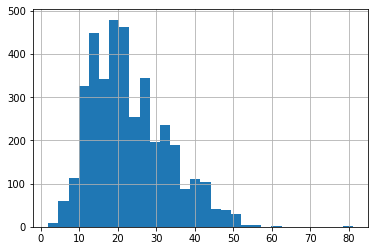

In [40]:
# Getting length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)


In [41]:
max_seq_len = 25

# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
# Converting Integer Sequences to Tensor

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [44]:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [45]:

# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [67]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      # Softmax activation function
      self.softmax= nn.LogSoftmax(dim=1)


    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)

      x = self.softmax(x)

      return x

In [48]:

model = BERT_Arch(bert)
# Use GPU
device = torch.device("cuda")
model = model.to(device)
print(device)

from transformers import AdamW, get_linear_schedule_with_warmup
#OPtimizer for the trasnformer
optimizer = AdamW(model.parameters(),lr=1e-3)


cuda


In [53]:

#Find the class weights
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight('balanced',classes=np.unique(train_labels),y=train_labels)
print(class_wts)


[2.63673469 0.55954959 1.1996286 ]


In [55]:
#Convert class weights to tensor
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
#Loss function
cross_entropy = nn.NLLLoss(weight=weights)
#Number of epochs
epochs = 10

In [62]:
# Function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]
  
  # Iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Append the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds

In [63]:
# Function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


In [70]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# For each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


TypeError: ignored